In [1]:
import os
import pickle
import numpy as np
import xml.etree.ElementTree as ET
import random
import svgwrite
from IPython.display import SVG, display
import tensorflow as tf
import time
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_bounds(data, factor):
  min_x = 0
  max_x = 0
  min_y = 0
  max_y = 0
    
  abs_x = 0
  abs_y = 0
  for i in range(len(data)):
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    abs_x += x
    abs_y += y
    min_x = min(min_x, abs_x)
    min_y = min(min_y, abs_y)
    max_x = max(max_x, abs_x)
    max_y = max(max_y, abs_y)
    
  return (min_x, max_x, min_y, max_y)

# old version, where each path is entire stroke (smaller svg size, but have to keep same color)
def draw_strokes(data, factor=10, svg_filename = 'sample.svg'):
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
    
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))

  lift_pen = 1
    
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
    
  command = "m"

  for i in range(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "

  the_color = "black"
  stroke_width = 1

  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))

  dwg.save()
  display(SVG(dwg.tostring()))

In [11]:

class DataLoader():
    def __init__(self, batch_size=50, tsteps=300, scale_factor = 10, U_items=10, limit = 500, alphabet="default"):
        self.data_dir = "./data"
        self.alphabet = alphabet
        self.batch_size = batch_size
        self.tsteps = tsteps
        self.scale_factor = scale_factor # divide data by this factor
        self.limit = limit # removes large noisy gaps in the data
        self.U_items = U_items

        data_file = os.path.join(self.data_dir, "strokes_ascii_training_data.cpkl")
        stroke_dir = self.data_dir+"/lineStrokes"
        ascii_dir = self.data_dir+"/ascii"

        if not (os.path.exists(data_file)) :
            print "creating training data cpkl file from raw source"
            self.preprocess(stroke_dir, ascii_dir, data_file)

        self.load_preprocessed(data_file)
        self.reset_batch_pointer()

    def preprocess(self, stroke_dir, ascii_dir, data_file):
        # create data file from raw xml files from iam handwriting source.
        print "Parsing dataset..."
        
        # build the list of xml files
        filelist = []
        # Set the directory you want to start from
        rootDir = stroke_dir
        for dirName, subdirList, fileList in os.walk(rootDir):
#             print('Found directory: %s' % dirName)
            for fname in fileList:
#                 print('\t%s' % fname)
                filelist.append(dirName+"/"+fname)

        # function to read each individual xml file
        def getStrokes(filename):
            tree = ET.parse(filename)
            root = tree.getroot()

            result = []

            x_offset = 1e20
            y_offset = 1e20
            y_height = 0
            for i in range(1, 4):
                x_offset = min(x_offset, float(root[0][i].attrib['x']))
                y_offset = min(y_offset, float(root[0][i].attrib['y']))
                y_height = max(y_height, float(root[0][i].attrib['y']))
            y_height -= y_offset
            x_offset -= 100
            y_offset -= 100

            for stroke in root[1].findall('Stroke'):
                points = []
                for point in stroke.findall('Point'):
                    points.append([float(point.attrib['x'])-x_offset,float(point.attrib['y'])-y_offset])
                result.append(points)
            return result
        
        # function to read each individual xml file
        def getAscii(filename, line_number):
            with open(filename, "r") as f:
                s = f.read()
            s = s[s.find("CSR"):]
            if len(s.split("\n")) > line_number+2:
                s = s.split("\n")[line_number+2]
                return s
            else:
                return ""
                
        # converts a list of arrays into a 2d numpy int16 array
        def convert_stroke_to_array(stroke):
            n_point = 0
            for i in range(len(stroke)):
                n_point += len(stroke[i])
            stroke_data = np.zeros((n_point, 3), dtype=np.int16)

            prev_x = 0
            prev_y = 0
            counter = 0

            for j in range(len(stroke)):
                for k in range(len(stroke[j])):
                    stroke_data[counter, 0] = int(stroke[j][k][0]) - prev_x
                    stroke_data[counter, 1] = int(stroke[j][k][1]) - prev_y
                    prev_x = int(stroke[j][k][0])
                    prev_y = int(stroke[j][k][1])
                    stroke_data[counter, 2] = 0
                    if (k == (len(stroke[j])-1)): # end of stroke
                        stroke_data[counter, 2] = 1
                    counter += 1
            return stroke_data

        # build stroke database of every xml file inside iam database
        strokes = []
        asciis = []
        for i in range(len(filelist)):
            if (filelist[i][-3:] == 'xml'):
                stroke_file = filelist[i]
#                 print 'processing '+stroke_file
                stroke = convert_stroke_to_array(getStrokes(stroke_file))
                
                ascii_file = stroke_file.replace("lineStrokes","ascii")[:-7] + ".txt"
                line_number = stroke_file[-6:-4]
                line_number = int(line_number) - 1
                ascii = getAscii(ascii_file, line_number)
                if len(ascii) > 10:
                    strokes.append(stroke)
                    asciis.append(ascii)
                else:
                    print "======>>>> Line length was too short. Line was: " + ascii
                
        assert(len(strokes)==len(asciis)), "There should be a 1:1 correspondence between stroke data and ascii labels."
        f = open(data_file,"wb")
        pickle.dump([strokes,asciis], f, protocol=2)
        f.close()
        print "Finished parsing dataset. Saved {} lines".format(len(strokes))


    def load_preprocessed(self, data_file):
        f = open(data_file,"rb")
        [self.raw_stroke_data, self.raw_ascii_data] = pickle.load(f)
        #[self.raw_stroke_dat, self.raw_ascii_dat] = pickle.load(f)
        #[self.raw_stroke_data, self.raw_ascii_data] = [self.raw_stroke_dat[:50], self.raw_ascii_dat[:50]] 
        f.close()

        # goes thru the list, and only keeps the text entries that have more than tsteps points
        self.stroke_data = []
        self.ascii_data = []
        counter = 0

        for i in range(len(self.raw_stroke_data)):
            data = self.raw_stroke_data[i]
            if len(data) > (self.tsteps+2):
                # removes large gaps from the data
                data = np.minimum(data, self.limit)
                data = np.maximum(data, -self.limit)
                data = np.array(data,dtype=np.float32)
                data[:,0:2] /= self.scale_factor
                
                self.stroke_data.append(data)
                self.ascii_data.append(self.raw_ascii_data[i])

        # minus 1, since we want the ydata to be a shifted version of x data
        self.num_batches = int(len(self.stroke_data) / self.batch_size)
        print "Loaded dataset:"
        print "   -> {} individual data points".format(len(self.stroke_data))
        print "   -> {} batches".format(self.num_batches)

    def next_batch(self):
        # returns a randomised, tsteps sized portion of the training data
        x_batch = []
        y_batch = []
        ascii_list = []
        for i in xrange(self.batch_size):
            data = self.stroke_data[self.idx_perm[self.pointer]]
            x_batch.append(np.copy(data[:self.tsteps]))
            y_batch.append(np.copy(data[1:self.tsteps+1]))
            ascii_list.append(self.ascii_data[self.idx_perm[self.pointer]])
            self.tick_batch_pointer()
        one_hots = [self.one_hot(s) for s in ascii_list]
        return x_batch, y_batch, ascii_list, one_hots
    
    def one_hot(self, s):
        #index position 0 means "unknown"
        if self.alphabet is "default":
            alphabet = " abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
        seq = [alphabet.find(char) + 1 for char in s]
        if len(seq) >= self.U_items:
            seq = seq[:self.U_items]
        else:
            seq = seq + [0]*(self.U_items - len(seq))
        one_hot = np.zeros((self.U_items,len(alphabet)+1))
        one_hot[np.arange(self.U_items),seq] = 1
        return one_hot

    def tick_batch_pointer(self):
        self.pointer += 1
        if (self.pointer >= len(self.stroke_data)):
            self.reset_batch_pointer()
    def reset_batch_pointer(self):
        self.idx_perm = np.random.permutation(len(self.stroke_data))
        self.pointer = 0
        print "pointer reset"

In [12]:
batch_size = 25
tsteps = 300
data_scale = 20
U_items = int(tsteps/20)
data_loader = DataLoader(batch_size=batch_size, tsteps=tsteps, \
                         scale_factor=data_scale, U_items=U_items, alphabet="default")

Loaded dataset:
   -> 11603 individual data points
   -> 464 batches
pointer reset


In [ ]:
print U_items

In [ ]:
def line_plot(strokes, title):
    plt.figure(figsize=(20,2))
    eos_preds = np.where(strokes[:,-1] == 1)
    eos_preds = [0] + list(eos_preds[0]) + [-1] #add start and end indices
    for i in range(len(eos_preds)-1):
        start = eos_preds[i]+1
        stop = eos_preds[i+1]
        plt.plot(strokes[start:stop,0], strokes[start:stop,1],'b-', linewidth=2.0)
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

In [ ]:
x, y, s, c = data_loader.next_batch()
print data_loader.pointer

r = x[0]
strokes = r.copy()
strokes[:,:-1] = np.cumsum(r[:,:-1], axis=0)
line_plot(strokes, s[0][:U_items])
plt.subplot(1, 1, 1)
plt.imshow(c[0][:U_items])
plt.gcf().set_size_inches(10, 4)
plt.show()

In [6]:
def tf_2d_normal(x1, x2, mu1, mu2, s1, s2, rho):
    # eq # 24 and 25 of http://arxiv.org/abs/1308.0850
    norm1 = tf.subtract(x1, mu1)
    norm2 = tf.subtract(x2, mu2)
    s1s2 = tf.multiply(s1, s2)
    z = tf.square(tf.div(norm1, s1))+tf.square(tf.div(norm2, s2))-2*tf.div(tf.multiply(rho, tf.multiply(norm1, norm2)), s1s2)
    negRho = 1-tf.square(rho)
    result = tf.exp(tf.div(-z,2*negRho))
    denom = 2*np.pi*tf.multiply(s1s2, tf.sqrt(negRho))
    result = tf.div(result, denom)
    return result

def get_lossfunc(z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr, z_eos, x1_data, x2_data, eos_data):
    result0 = tf_2d_normal(x1_data, x2_data, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr)
    # implementing eq # 26 of http://arxiv.org/abs/1308.0850
    epsilon = 1e-20
    result1 = tf.multiply(result0, z_pi)
    result1 = tf.reduce_sum(result1, 1, keep_dims=True)
    result1 = -tf.log(tf.maximum(result1, 1e-20)) # at the beginning, some errors are exactly zero.

    result2 = tf.multiply(z_eos, eos_data) + tf.multiply(1-z_eos, 1-eos_data)
    result2 = -tf.log(result2)

    result = result1 + result2
    return tf.reduce_sum(result)

# below is where we need to do MDN splitting of distribution params
def get_mixture_coef(output):
    # returns the tf slices containing mdn dist params
    # ie, eq 18 -> 23 of http://arxiv.org/abs/1308.0850
    z = output
    z_eos = z[:, 0:1]
    z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr = tf.split(axis=1, num_or_size_splits=6, value=z[:, 1:])

    # process output z's into MDN paramters

    # end of stroke signal
    z_eos = tf.sigmoid(z_eos) # should be negated, but doesn't matter.

    b=0 # BIAS

    # softmax all the pi's:
    max_pi = tf.reduce_max(z_pi, 1, keep_dims=True)
    z_pi = tf.subtract(z_pi, max_pi)
    z_pi = tf.exp(z_pi*(1+b))
    normalize_pi = tf.reciprocal(tf.reduce_sum(z_pi, 1, keep_dims=True))
    z_pi = tf.multiply(normalize_pi, z_pi)

    # exponentiate the sigmas and also make corr between -1 and 1.
    z_sigma1 = tf.exp(z_sigma1-b)
    z_sigma2 = tf.exp(z_sigma2-b)
    z_corr = tf.tanh(z_corr)

    return [z_pi, z_mu1, z_mu2, z_sigma1, z_sigma2, z_corr, z_eos]

In [16]:
class Model():
    def __init__(self, args, bias=0, infer=False):
        self.args = args
        self.char_vec_len = len(args.alphabet) + 1
        self.train = args.train
        self.dropout = args.dropout

        if infer:
            args.batch_size = 1
            args.seq_length = 1

        tf.reset_default_graph()

        self.input_x = tf.placeholder(tf.float32, [None,args.seq_length,3], name='x_batch')
        self.input_y = tf.placeholder(tf.float32, [None,args.seq_length,3], name='y_batch')
        self.input_ascii = tf.placeholder(tf.float32, [None, args.ascii_step, self.char_vec_len], name='input_ascii')

        self.graves_initializer = tf.truncated_normal_initializer(mean=0., stddev=.075, seed=None, dtype=tf.float32)
        self.window_b_initializer = tf.truncated_normal_initializer(mean=-3.0, stddev=.25, seed=None, dtype=tf.float32)

        N = args.batch_size
        NOUT = 1 + args.num_mixture * 6

        W = tf.get_variable("W", [args.rnn_size,NOUT], initializer=self.graves_initializer)
        b = tf.get_variable("b", [NOUT], initializer=self.graves_initializer)
        W_attn = tf.get_variable("W_attn", [args.rnn_size,args.num_gaussian*3], initializer=self.graves_initializer)
        b_attn = tf.get_variable("b_attn", [args.num_gaussian*3], initializer=self.window_b_initializer)

        cell_func = tf.contrib.rnn.LSTMCell # could be GRUCell or RNNCell
        def lstm_cell():
            if (self.train and self.dropout < 1): # training mode
                return tf.contrib.rnn.DropoutWrapper(cell_func(args.rnn_size, state_is_tuple=True, initializer=self.graves_initializer), output_keep_prob = self.dropout)
            else:
                return cell_func(args.rnn_size, state_is_tuple=True, initializer=self.graves_initializer)

        cell_1 = lstm_cell()
        self.cell_1 = cell_1
        self.in_state_1 = cell_1.zero_state(args.batch_size, tf.float32)
        output_1, final_state_1 = tf.nn.dynamic_rnn(cell_1, self.input_x, initial_state=self.in_state_1)
        self.out_state_1 = tf.identity(final_state_1, name='out_state_1')

        output_1_t = [tf.squeeze(o_, [1]) for o_ in tf.split(output_1, args.seq_length, 1)]
        #print len(output_1), output_1[0].shape

        def get_phi(alpha, beta, kappa):
            u = np.arange(args.ascii_step)
            kappa_term = tf.square(tf.subtract(kappa,u))
            exp_term = tf.multiply(-beta,kappa_term)
            phi_k = tf.multiply(alpha, tf.exp(exp_term))
            phi = tf.reduce_sum(phi_k,1, keep_dims=True)
            return phi

        self.prev_kappa = tf.zeros([args.batch_size, args.num_gaussian,1])
        char = tf.zeros([args.batch_size, args.seq_length, self.char_vec_len])

        output_1_list = []
        prev_kappa = self.prev_kappa
        for t in range(args.seq_length):
            attn = tf.matmul(output_1_t[t], W_attn) + b_attn
            attn_k = tf.exp(tf.reshape(attn, [-1, 3*args.num_gaussian,1]))
            [alpha, beta, kappa] = tf.split(attn_k, 3, axis=1)
            kappa = kappa + prev_kappa
            phi = get_phi(alpha, beta, kappa)
            #print phi.shape
            c = tf.matmul(phi,self.input_ascii)
            c = tf.squeeze(c, [1])
            #print c.shape
            output_1_list.append(c)
            prev_kappa = tf.reduce_mean(kappa, axis=1, keep_dims=True)
            #print prev_kappa.shape

        #tf.concat((output_1[t],c,self.input_x[:,t]),1)
        #print output_1_list[0].shape
        self.output_1_c = tf.stack(output_1_list, axis=1)
        self.output_1 = tf.concat([output_1, self.output_1_c, self.input_x], axis=2)
        print self.output_1.shape

        self.new_kappa = prev_kappa

        cell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(args.num_layers)], state_is_tuple=True)
        self.cell = cell
        init_state = cell.zero_state(N, tf.float32)
        self.init_state = init_state
        states_series, current_state = tf.nn.dynamic_rnn(cell, self.output_1, initial_state=self.init_state)
        states_series = tf.reshape(states_series, [-1, args.rnn_size])
        self.state_out = tf.identity(current_state, name='state_out')
        output = tf.matmul(states_series, W) + b
        #[x1, x2, eos] = tf.split(axis=1, num_or_size_splits=3, value=flat_data)
        #eos = tf.sigmoid(eos)

        flat_target_data = tf.reshape(self.input_y,[-1, 3])
        [x1_data, x2_data, eos_data] = tf.split(axis=1, num_or_size_splits=3, value=flat_target_data)

        #x1_loss = tf.losses.mean_squared_error(x1_data, x1)
        #x2_loss = tf.losses.mean_squared_error(x2_data, x2)
        #eos_loss = tf.losses.softmax_cross_entropy(eos_data, eos)



        [o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_eos] = get_mixture_coef(output)

        self.pi = o_pi
        self.mu1 = o_mu1
        self.mu2 = o_mu2
        self.sigma1 = o_sigma1
        self.sigma2 = o_sigma2
        self.corr = o_corr
        self.eos = o_eos

        lossfunc = get_lossfunc(o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_eos, x1_data, x2_data, eos_data)
        self.cost = lossfunc / (args.batch_size * args.seq_length)

        self.lr = tf.Variable(0.0, trainable=False)
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(self.cost, tvars), 10.)
        optimizer = tf.train.AdamOptimizer(self.lr)
        self.train_op = optimizer.apply_gradients(zip(grads, tvars))

    def sample(self, sess, text, data_loader, num=1200):
        def get_pi_idx(x, pdf):
            N = pdf.size
            accumulate = 0
            for i in range(0, N):
                accumulate += pdf[i]
                if (accumulate >= x):
                    return i
            print('error with sampling ensemble')
            return -1

        def sample_gaussian_2d(mu1, mu2, s1, s2, rho):
            mean = [mu1, mu2]
            cov = [[s1*s1, rho*s1*s2], [rho*s1*s2, s2*s2]]
            x = np.random.multivariate_normal(mean, cov, 1)
            return x[0][0], x[0][1]

        prev_x = np.zeros((1, 1, 3), dtype=np.float32)
        prev_x[0, 0, 2] = 1 # initially, we want to see beginning of new stroke
        prev_state = sess.run(self.cell.zero_state(1, tf.float32))
        prev_state_1 = sess.run(self.cell_1.zero_state(1, tf.float32))
        print self.args.num_gaussian
        prev_kappa = np.zeros([1, self.args.num_gaussian,1])
        c = np.reshape(data_loader.one_hot(text), (1,-1,model.char_vec_len))

        strokes = np.zeros((num, 3), dtype=np.float32)
        mixture_params = []

        p = []

        for i in range(num):

            feed = {self.input_x: prev_x, self.input_ascii:c, self.init_state:prev_state, self.in_state_1:prev_state_1, self.prev_kappa:prev_kappa}

            [o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_eos, next_state, next_state_1, next_kappa, out_attn] = sess.run([self.pi, self.mu1, self.mu2, self.sigma1, self.sigma2, self.corr, self.eos, self.state_out, self.out_state_1, self.new_kappa, self.output_1_c],feed)

            p.append(out_attn.reshape((-1)))


            idx = get_pi_idx(random.random(), o_pi[0])

            eos = 1 if random.random() < o_eos[0][0] else 0

            next_x1, next_x2 = sample_gaussian_2d(o_mu1[0][idx], o_mu2[0][idx], o_sigma1[0][idx], o_sigma2[0][idx], o_corr[0][idx])

            strokes[i,:] = [next_x1, next_x2, eos]

            params = [o_pi[0], o_mu1[0], o_mu2[0], o_sigma1[0], o_sigma2[0], o_corr[0], o_eos[0]]
            mixture_params.append(params)

            prev_x = np.zeros((1, 1, 3), dtype=np.float32)
            prev_x[0][0] = np.array([next_x1, next_x2, eos], dtype=np.float32)

            prev_state = tuple(
                [tf.contrib.rnn.LSTMStateTuple(next_state[idx][0],next_state[idx][1])
                for idx in range(args.num_layers)]
            )

            prev_state_1 = tuple(next_state_1)
            prev_kappa = next_kappa*np.ones([3,1])

        plt.subplot(1, 1, 1)

        x = (np.array(p))#[:50][256:320]
        #plt.imshow(x[:50,256:320])
        #plt.gcf().set_size_inches(20, 8)
        #plt.show()

        strokes[:,0:2] *= self.args.data_scale
        return strokes, mixture_params

model = Model(args)

(1, 1, 185)


In [15]:
a = np.array([[[2]]])
b = np.ones([3,1])
print b
c = a*b
print c
print c.shape

[[ 1.]
 [ 1.]
 [ 1.]]
[[[ 2.]
  [ 2.]
  [ 2.]]]
(1, 3, 1)


In [7]:
class FakeArgParse():
    def __init__(self):
        pass
args = FakeArgParse()

args.rnn_size = 128
args.num_layers = 2
args.batch_size = batch_size
args.seq_length = tsteps
args.num_epochs = 30
args.save_every = 50
args.model_dir = './output'
args.grad_clip = 10
args.learning_rate = 0.0001
args.decay_rate = 0.95
args.num_mixture = 10
args.data_scale = 20
args.num_gaussian = 3
args.ascii_step = U_items
args.alphabet = ' abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
args.train = True
args.dropout = 0.8


In [ ]:
print len(args.alphabet)

In [ ]:
saver = tf.train.Saver(tf.global_variables())

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    #sess.run(tf.assign(model.lr, args.learning_rate))
    for e in range(args.num_epochs):
        sess.run(tf.assign(model.lr, args.learning_rate * (args.decay_rate ** e)))
        data_loader.reset_batch_pointer()
        
        #v_x, v_y = data_loader.validation_data()
        #valid_feed = {x_batch: v_x, y_batch: v_y}
        #for b in range(2):
        #    i = e * 1 + b
        for b in range(data_loader.num_batches):
            i = e * data_loader.num_batches + b
            start = time.time()
            x, y, s, c = data_loader.next_batch()
            feed = {model.input_x: x, model.input_y: y, model.input_ascii:c}
            train_loss, _ = sess.run([model.cost, model.train_op], feed)
            #valid_loss, _ = sess.run([total_loss, train_step], valid_feed)
            end = time.time()
            print(
                "{}/{} (epoch {}), train_loss = {:.3f}, time/batch = {:.3f}"  \
                .format(
                    i,
                    args.num_epochs * data_loader.num_batches,
                    e, 
                    train_loss, end - start))
            if (e * data_loader.num_batches + b) % args.save_every == 0 and ((e * data_loader.num_batches + b) > 0):
                    checkpoint_path = os.path.join(args.model_dir, 'model')
                    saver.save(sess, checkpoint_path)
                    print("model saved to {}".format(checkpoint_path))
                    with open('checkpoint', "w") as raw:
                        raw.write('model_checkpoint_path: "model"\nall_model_checkpoint_paths: "model"')

pointer reset
0/13920 (epoch 0), train_loss = 4.772, time/batch = 6.390
1/13920 (epoch 0), train_loss = 4.535, time/batch = 3.380
2/13920 (epoch 0), train_loss = 4.745, time/batch = 3.354
3/13920 (epoch 0), train_loss = 4.155, time/batch = 3.371
4/13920 (epoch 0), train_loss = 4.257, time/batch = 3.349
5/13920 (epoch 0), train_loss = 4.053, time/batch = 3.396
6/13920 (epoch 0), train_loss = 4.106, time/batch = 3.368
7/13920 (epoch 0), train_loss = 3.967, time/batch = 3.361

In [ ]:
with open('checkpoint', "w") as raw:
    raw.write('model_checkpoint_path: "model"\nall_model_checkpoint_paths: "model"')

In [17]:
tf.reset_default_graph()
model = Model(args, 0, True)
sess = tf.InteractiveSession()
saver = tf.train.Saver()

ckpt = tf.train.get_checkpoint_state('model_data/temp1')
print("loading model: ", ckpt.model_checkpoint_path)

saver.restore(sess, ckpt.model_checkpoint_path)

(1, 1, 185)
('loading model: ', u'model_data/temp1/model')
INFO:tensorflow:Restoring parameters from model_data/temp1/model


INFO:tensorflow:Restoring parameters from model_data/temp1/model


3


/home/gaurav/Desktop/assignment1/.env/lib/python2.7/site-packages/ipykernel/__main__.py:133: RuntimeWarning: covariance is not positive-semidefinite.


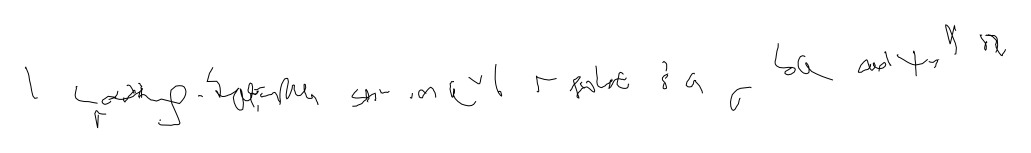

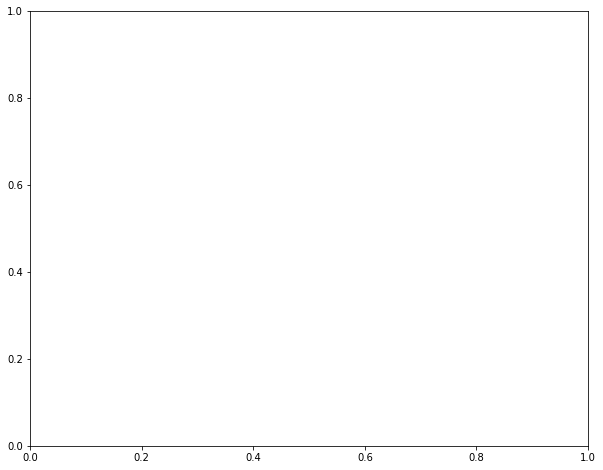

In [18]:
def sample_stroke():
    [strokes, params] = model.sample(sess, "Jai shri krishna", data_loader, 1000)
    draw_strokes(strokes, factor=10, svg_filename = 'sample'+'.normal.svg')

sample_stroke()